To do:

- Try wilcoxon test to compare two distributions
- ~~Feature selection One-vs-many seems to give good seperation~~ This may not be the case -- implemented ``majority``, but the accuracy is not high
- Try to find the best scoring function

### Load Context

In [1]:
import os
import sys
import scipy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
os.chdir("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/")
sys.path.append("/Users/kipnisal/DS/BiblicalScripts/bib-scripts/src")

params = catalog.load('parameters')

data = catalog.load("data_proc")
vocab = catalog.load("vocabulary")

known_authors = params['known_authors']

2022-05-12 11:19:19,461 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
2022-05-12 11:19:19,463 - kedro.io.data_catalog - INFO - Loading data from `data_proc` (CSVDataSet)...
2022-05-12 11:19:19,664 - kedro.io.data_catalog - INFO - Loading data from `vocabulary` (CSVDataSet)...


In [46]:
import numpy as np
from scipy.stats import f as fdist
from scipy.stats import t as tdist
from scipy.stats import norm
from scipy.stats import ttest_ind as ttest
from scipy.stats import levene
from scipy.stats import bartlett

def discrepancy(cnt1, cnt2, **kwargs):
    
    disc_type = kwargs.get('test', 'HC')
    gamma = kwargs.get('gamma', .2)
    
    pvals = bin_allocation_test(cnt1, cnt2)
    mt = MultiTest(pvals)
    if disc_type == 'HC':
        hc,_ = mt.hc_star(gamma = gamma)
        return hc
    if disc_type == 'Fisher':
        return np.mean(-np.log(pvals))
    
    raise ValueError("Only HC-discrepancy is supported")

def merge_list_of_dataframes(lo_df):
    dfr = pd.DataFrame()
    for df in lo_df:
        dfr = dfr.append(df, ignore_index=True)
    return dfr
        
class CompareDocsRelativeResponse(object):
    """
    Upon call, this object need to return 
    HC discrepancy of two points
    
    Can use CompareDocs model but does not have to
    The issue is how to decide on a vocabulary
    
    """
    def __init__(self, compare_docs_model, discrepancy_type='HC'):
        self.cd_model = compare_docs_model
        self.disc_type = discrepancy_type
        

    def __call__(self, X1, X2):
        cnt1 = self.cd_model.count_words(merge_list_of_dataframes(X1)).n
        cnt2 = self.cd_model.count_words(merge_list_of_dataframes(X2)).n
        return discrepancy(cnt1, cnt2, disc_type=self.disc_type)
    

def test_f(scores0, scores1):
    def _sum_of_squares(scores):
            return np.sum((scores - np.mean(scores)) ** 2)
        
    ss0 = _sum_of_squares(scores0)
    ss1 = _sum_of_squares(scores1)
    fstat = ss1 / ss0
    return fstat, fdist.sf(ss1 / ss0, dfn=len(scores1)-1,dfd=len(scores0)-1)


def test_bartlett(scores0, scores1):
    return bartlett(scores0, scores1)


def test_t_2smp(scores0, scores1):
    return ttest(scores0, scores1)


def test_t(scores0, scores1):
    mu = np.mean(scores1[:-1])
    s = np.std(scores1[:-1], ddof=1)
    t = (scores1[-1] - mu) / ( s * np.sqrt(1 + 1/len(scores1[:-1]) ) )
    return t, tdist.sf(t, df=len(scores1) - 2) # one-sided


def test_wilcoxon(scores0, scores1):
    return scipy.stats.ranksums(scores0, scores1)


def test_perm(scores0, scores1):
    """
    Two-sample permutation test
    """
    return ttest(scores0, scores1, permutations=5000)


def test_linear(scores0, scores1):
    mu = np.mean(scores0)
    t = (scores1[-1] - mu) / np.std(scores0, ddof=1)
    return t, tdist.sf(t, df=len(scores0) - 1) # one-sided


def test_levene(scores0, scores1):
    return levene(scores0, scores1)

In [67]:
from twosample import bin_allocation_test
from multitest import MultiTest
from typing import List

        
class DivisibleClassClassifier(object):
    """
    ANOVA-based classification using a base
    response model. The relative response function is provided 
    in the fitting stage
    """
    
    def __init__(self):
        self._data = {}
        self.rr_func = None
        self.classes_ = []
        self.no_samples = {}
    
    def fit(self, relative_response_func, X: List, y: List):
        """
        
        Params:
            :relative_response_model: a model with method 'predict' 
            that returns the relative response of two datasets
            
            :X:   data
            :y:   labels
            
        """
        self.rr_func = relative_response_func
        self.no_samples = {}
        self._data = {}
        self.classes_ = list(np.unique(y))
        self.scores_ = {}
        for cls in self.classes_:
            X_cls = [X[i] for i,label in enumerate(y) if label == cls]
            self._data[cls] = X_cls
            self.scores_[cls] = self._within_corpus_disc(X_cls)
            self.no_samples[cls] = len(X_cls)
            
    def predict(self, x):
        probs = self.predict_proba(x)
        res = {}
        for k in probs:
            res[k] = -np.log(probs[k])
        return res
        
    def predict_table(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            stat, pval = self.test(scores0, scores1)
            df = df.append({'cls' : cls,
                            'scores1' : scores1,
                            'scores0' : scores0,
                            'n1' : len(scores0),
                            'n2' : len(scores1),
                            'stat' : stat, 
                            'pval' : pval
                           }, ignore_index=True)
        return df
        
    def predict_many(self, x):
        df = pd.DataFrame()
        for cls in self.classes_:
            X_extended = self._data[cls] + [x]
            scores1 = self._within_corpus_disc(X_extended)
            scores0 = self.scores_[cls]
            res = self.many_tests(scores0, scores1)
            dfr = dict({'cls' : cls,
                   'n1' : len(scores0),
                   'n2' : len(scores1),
                    **res})
            df = df.append(dfr, ignore_index=True)
        return df
            
    def predict_proba(self, x):
        """
        Returns class probabilities
        
        Probabilites are obtained via f-test:
        SS of each class with x included versue SS without x
        """
        df = self.predict_table(x)
        probs = dict(zip(df.cls, df.pval))
        return probs
    
    
    def test(self, scores0, scores1):
        return test_t(scores0, scores1)
    
    
    def many_tests(self, scores0, scores1):
        return dict(
        raw = scores1[-1], 
        pval_t = test_t(scores0, scores1)[1],
        pval_f = test_f(scores0, scores1)[1],
        pval_bartlett = test_bartlett(scores0, scores1)[1],
        pval_2smp = test_t_2smp(scores0, scores1)[1],
        pval_tLDA = test_linear(scores0, scores1)[1],
        pval_levene = test_levene(scores0, scores1)[1],
        pval_wilcox = test_wilcoxon(scores0, scores1).pvalue,
        pval_2smp_perm = test_perm(scores0, scores1)[1]
        )
        
        
    def _within_corpus_disc(self, X: List):
        """
        Find relative response of each element in X compared to the other elements.
        
        Params:
            :X:  data
        
        Returns:
            :scores:     relative response
        """
        scores = np.zeros(len(X))
        for i,x in enumerate(X):
            scores[i] = self.rr_func([x], [X[j] for j,_ in enumerate(X) if j != i])
        return scores
        

In [68]:
from biblical_scripts.pipelines.sim.nodes import (
    build_model, model_predict, _prepare_data)
from sklearn.model_selection import KFold

In [69]:
data = _prepare_data(data[data.to_report])
data_known = data[data.author.isin(known_authors)]
lo_docs = data_known.doc_id.unique()

In [70]:
def arrange_training_data(data):
    X = []
    y = []
    lo_authors = data.author.unique()
    for auth in lo_authors:
        ds_auth = data[data.author == auth]
        lo_docs = ds_auth.doc_id.unique()
        Xauth = [c[1] for c in ds_auth.groupby('doc_id')]
        X += Xauth
        y += [auth] * len(Xauth)
    return X, y


n_splits = 10
shuffle = True


df_res = pd.DataFrame()
train_doc_names = data_known.filter(['doc_id', 'author']).drop_duplicates()
kf = KFold(n_splits=10, shuffle=shuffle)
for train_index, test_index in tqdm(kf.split(train_doc_names)):
    test_docs = train_doc_names.iloc[test_index]['doc_id']
    ds1 = data_known[data_known.doc_id.isin(test_docs)] # test docs data
    data_train = data_known.drop(ds1.index) # drop whatever is in test
    
    md, vocab = build_model(data_train, vocab, params['model'])
    cdrr = CompareDocsRelativeResponse(md)
    
    X, y = arrange_training_data(data_train)
    anova_cls = DivisibleClassClassifier()
    anova_cls.fit(cdrr, X, y)
    
    for doc in test_docs:
        ds11 = data_known[data_known.doc_id == doc]
        res = anova_cls.predict_many(ds11)
        res['doc_tested'] = doc
        res['len'] = len(ds11)
        df_res = df_res.append(res, ignore_index=True)

0it [00:00, ?it/s]

2022-05-12 15:22:42,075 - root - INFO - Building CompareDocs model using 45 documents. 


1it [00:09,  9.70s/it]

2022-05-12 15:22:51,763 - root - INFO - Building CompareDocs model using 45 documents. 


2it [00:18,  9.42s/it]

2022-05-12 15:23:00,979 - root - INFO - Building CompareDocs model using 45 documents. 


3it [00:28,  9.55s/it]

2022-05-12 15:23:10,681 - root - INFO - Building CompareDocs model using 45 documents. 


4it [00:38,  9.83s/it]

2022-05-12 15:23:20,960 - root - INFO - Building CompareDocs model using 45 documents. 


5it [00:50, 10.35s/it]

2022-05-12 15:23:32,243 - root - INFO - Building CompareDocs model using 45 documents. 


6it [00:59, 10.13s/it]

2022-05-12 15:23:41,928 - root - INFO - Building CompareDocs model using 45 documents. 


7it [01:10, 10.19s/it]

2022-05-12 15:23:52,236 - root - INFO - Building CompareDocs model using 45 documents. 


8it [01:20, 10.14s/it]

2022-05-12 15:24:02,275 - root - INFO - Building CompareDocs model using 45 documents. 


9it [01:29,  9.98s/it]

2022-05-12 15:24:11,897 - root - INFO - Building CompareDocs model using 45 documents. 


10it [01:39,  9.94s/it]


In [64]:
df_res.loc[: ,'true_class'] = df_res.doc_tested.apply(lambda x : x.split('|')[0])
#df_res.loc[:, 'neg_raw'] = -df_res['raw']

for value in df_res.columns[df_res.columns.str.contains(r'pval|neg_raw|avg')]:        
    idx = df_res.groupby('doc_tested')[value].idxmax(axis=1)
    acc = np.mean(df_res.loc[idx, 'cls'] == df_res.loc[idx, 'true_class'])
    print(f"Accuracy with {value} = {acc}")
    #df_res['predicted_class'] = df_res[['Dtr', 'DtrH', 'P']].idxmin(axis=1)
    #print("Accuracy: ", np.mean(df_res.predicted_class == df_res.true_class))

Accuracy with pval_2smp = 0.56
Accuracy with pval_2smp_perm = 0.58
Accuracy with pval_bartlett = 0.52
Accuracy with pval_f = 0.66
Accuracy with pval_levene = 0.42
Accuracy with pval_t = 0.8
Accuracy with pval_tLDA = 0.8
Accuracy with pval_wilcox = 0.68


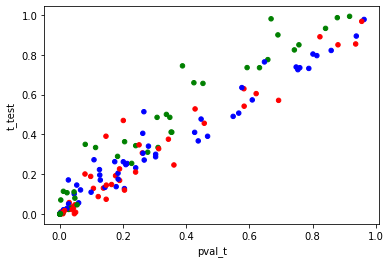

<ipython-input-66-9d991b5a82ca>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<ipython-input-66-9d991b5a82ca>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,cls,n1,n2,doc_tested,raw,true_class,pval_tLDA,pval_t,t-score,t_test,"('value', 'mean')","('value', 'count')"
15,Dtr,8.0,9.0,Dtr|Deut.19,2.169542,Dtr,0.263881,0.201162,0.077118,0.470344,1.169069,8
90,Dtr,7.0,8.0,Dtr|Deut.15,2.744395,Dtr,0.046568,0.080018,0.891548,0.201120,1.078535,8
93,Dtr,7.0,8.0,Dtr|Deut.16,1.958934,Dtr,0.157389,0.146356,0.287108,0.391171,1.192409,8


In [66]:
# compare with previous evaluation

df = df_res.merge(probs.rename(columns={'corpus' : 'cls'}), on=['doc_tested', 'cls'])
df['t_test'] = np.exp(-df['t_test'])
df1 = df.filter(['cls', 'n1', 'n2', 'doc_tested', 'raw', 'len', 'true_class', 'pval_tLDA', 'pval_t', 't-score', 't_test', "('value', 'mean')", "('value', 'count')"])

color_dic = {'Dtr' : 'red', 'DtrH' : 'green', 'P' : 'blue'}
colors = [color_dic[a] for a in df1['cls'].values]

df1.plot.scatter(x='pval_t', y='t_test', color=colors)
plt.show()

df1[df1.cls == 'Dtr'][df1.true_class == 'Dtr'][df1.t_test/df1.pval_t > 1.1]

In [15]:
dfr = df_res.filter(regex=r'(pval_|raw|cls|doc_tested|true_class|avg)').pivot(columns = 'cls', index='doc_tested')

In [16]:
color_dic = {'Dtr' : 'red', 'DtrH' : 'green', 'P' : 'blue'}
colors = [color_dic[a] for a in dfr['true_class']['P'].values]

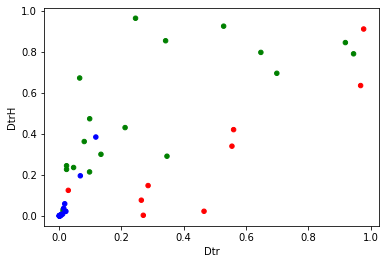

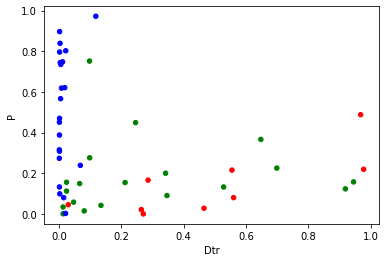

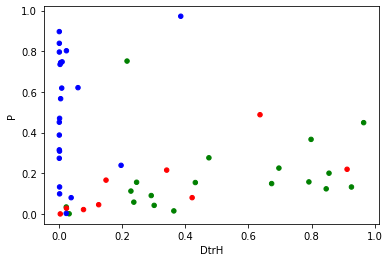

In [17]:
value = 'pval_tLDA'

for cls1 in ['Dtr', 'DtrH', 'P'] :
    for cls2 in ['Dtr', 'DtrH', 'P']:
        if cls1 < cls2:
            dfr.plot.scatter(x=(value, cls1), y=(value, cls2),
                             color=colors)
            #plt.xlim((0,0.1))
            #plt.ylim((0,0.1))
            plt.xlabel(cls1)
            plt.ylabel(cls2)
            plt.show()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])